# Evaluate Scaling
Evaluate the scaling behavior of CP2K on Polaris.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm 
import pandas as pd
import numpy as np

## Load the runtime data
It's saved in a file named "runtimes.json"

In [2]:
data = pd.read_json("runtimes.json", lines=True)

Compute some derived quantities

In [3]:
data['node-hrs'] = data['num_nodes'] * data['run_time'] / 3600
data.tail()

,name,composition,n_atoms,n_electrons,num_nodes,run_type,max_steps,steps,run_time,hostname,node-hrs
26,qmof-5f57dd4,C56H52Cd3N10O18S6,145,506,8,md,4,5,74.470829,polaris-login,0.165491
27,qmof-2102beb,C72H84N16O34Zn8,214,752,8,md,4,5,98.667713,polaris-login,0.219262
28,qmof-c861c48,C144H96Fe6N60,306,1068,8,md,4,5,315.659189,polaris-login,0.701465
29,qmof-918ced2,C172H216Cd4N16O36,444,1248,8,md,4,5,127.891003,polaris-login,0.284202
30,qmof-40f119f,C6H4CuN4S2,17,71,8,md,1,2,36.079826,polaris-login,0.080177


## Plot Runtime vs Electron Count
Determine whether CP2K is indeed operating like a linear-scaling DFT code

In [4]:
single_node_md = data.query("num_nodes==1 and max_steps==4 and run_type=='md'")

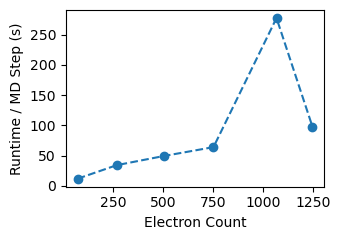

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(single_node_md['n_electrons'], single_node_md['run_time'] / single_node_md['steps'], '--o')

ax.set_xlabel('Electron Count')
ax.set_ylabel('Runtime / MD Step (s)')
fig.tight_layout()
fig.savefig('figures/runtime-vs-electron-count.pdf')
fig.savefig('figures/runtime-vs-electron-count.png', dpi=320)

With exceptions, we get mostly linear scaling. Not sure what's up with the 1000-electron example

## Plot the Time to Convergence for Relaxation
Get an idea how long it takes to converge a structural relaxation, starting from the VASP structure.

In [6]:
single_node_qn = data.query("num_nodes==2 and run_type=='qn'")

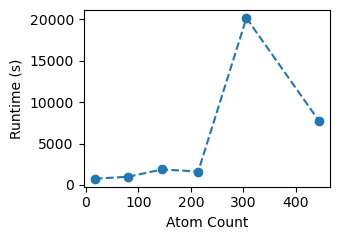

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(single_node_qn['n_atoms'], single_node_qn['run_time'], '--o')

ax.set_xlabel('Atom Count')
ax.set_ylabel('Runtime (s)')
fig.tight_layout()
fig.savefig('figures/relaxtion-runtime.pdf')
fig.savefig('figures/relaxtion-runtime.png', dpi=320)

## Determine Scaling Efficiency
Show the speedup as a function of number of nodes

In [8]:
scaling = data.query('run_type=="md" and max_steps==4')
scaling = scaling.merge(single_node_md[['name', 'node-hrs', 'run_time']], on='name', suffixes=('', '_single'))
scaling.head()

,name,composition,n_atoms,n_electrons,num_nodes,run_type,max_steps,steps,run_time,hostname,node-hrs,node-hrs_single,run_time_single
0,qmof-40f119f,C6H4CuN4S2,17,71,1,md,4,5,58.415346,polaris-login,0.016226,0.016226,58.415346
1,qmof-40f119f,C6H4CuN4S2,17,71,2,md,4,5,47.826400,polaris-login,0.026570,0.016226,58.415346
2,qmof-40f119f,C6H4CuN4S2,17,71,4,md,4,5,43.880473,polaris-login,0.048756,0.016226,58.415346
3,qmof-40f119f,C6H4CuN4S2,17,71,8,md,4,5,51.989437,polaris-login,0.115532,0.016226,58.415346
4,qmof-bd41929,C40H28CuN4O8,81,267,1,md,4,5,170.298485,polaris-login,0.047305,0.047305,170.298485


In [9]:
scaling['efficiency'] = scaling['node-hrs_single'] / scaling['node-hrs']

Text(0.5, 1.0, 'CP2K Scaling Efficiency on Polaris')

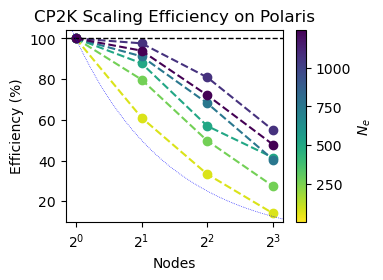

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

cmap = cm.get_cmap('viridis_r')
vmin, vmax = 1, scaling['n_electrons'].max()

# Loop over sizes of water clusters
for size, group in scaling.groupby('n_electrons'):
    # Get the average efficiency for each node count
    mean_subset = group.groupby('num_nodes').mean(numeric_only=True)

    # Determine color based on numebr of molecules
    color = cmap((size - vmin) / (vmax - vmin))
    ax.plot(mean_subset.index, mean_subset['efficiency'] * 100, '--o', c=color)

ax.set_xscale('log', base=2)
    
# Make a line at 100%
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())

ax.plot(ax.get_xlim(), [100]*2, 'k--', lw=1)

# Make a 'fail' line
x = np.logspace(*np.log10(ax.get_xlim()), 128)
ax.plot(x, 100./x, 'b:', lw=0.5)

# Make a colorbar
l = ax.scatter([], [], c=[], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(l, label='$N_e$')

ax.set_xlabel('Nodes')
ax.set_ylabel('Efficiency (%)')
ax.set_title('CP2K Scaling Efficiency on Polaris')